# Task 3: Customer Segmentation / Clustering

**Step 1: Import Required Libraries**

Start by importing the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

**Step 2: Prepare the Data**

Load and preprocess the data to create customer profiles.

2.1 - Load Data

In [2]:
# Load datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

# Merge Customers and Transactions data
merged = pd.merge(transactions, customers, on="CustomerID", how="left")

2.2 - Aggregate to Create Customer Profiles: Aggregate transaction data for each customer.

In [3]:
customer_profile = merged.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending
    'Quantity': 'sum',    # Total products purchased
}).reset_index()

# Normalize Date into a feature
customers['SignupDays'] = (pd.to_datetime('2025-01-01') - pd.to_datetime(customers['SignupDate'])).dt.days

# Merge customer profile with SignupDays
customer_profile = pd.merge(customer_profile, customers[['CustomerID', 'Region', 'SignupDays']], on='CustomerID', how='left')

# Encode 'Region' column
customer_profile['Region'] = customer_profile['Region'].astype('category').cat.codes

2.3 - Standardize Features: Scale the numerical data to ensure all features contribute equally.

In [4]:
scaler = StandardScaler()
features = ['TotalValue', 'Quantity', 'SignupDays', 'Region']
customer_profile_scaled = scaler.fit_transform(customer_profile[features])

**Step 3: Perform Clustering**

Use KMeans for clustering.

3.1 - Choose the Number of Clusters (K): Perform an elbow method to determine the optimal number of clusters:

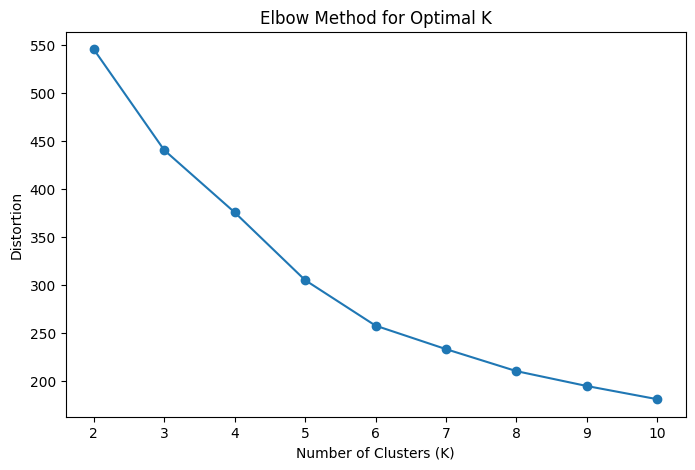

In [5]:
distortions = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_profile_scaled)
    distortions.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), distortions, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal K')
plt.show()

3.2 - Fit KMeans with Optimal K: Choose a value of K from the elbow curve (e.g., K=6)

In [26]:
kmeans = KMeans(n_clusters=6, random_state=42)
customer_profile['Cluster'] = kmeans.fit_predict(customer_profile_scaled)

**Step 4: Evaluate Clustering Performance**

4.1 - Calculate Davies-Bouldin Index (DB Index): A lower DB Index indicates better-defined clusters.

In [27]:
db_index = davies_bouldin_score(customer_profile_scaled, customer_profile['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 1.0573276115484942


4.2 - Calculate Silhouette Score (Silhouette Average): Measures how similar an object is to its own cluster compared to other clusters. The score ranges from -1 to 1, where a higher value indicates better clustering.

In [28]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(customer_profile_scaled, customer_profile['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.2970203131991246


4.3 - Calculate Calinski-Harabasz Index (Calinski Harabasz): Measures the ratio of the sum of the between-cluster dispersion and within-cluster dispersion. A higher score indicates better-defined clusters.

In [29]:
from sklearn.metrics import calinski_harabasz_score

calinski_harabasz = calinski_harabasz_score(customer_profile_scaled, customer_profile['Cluster'])
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

Calinski-Harabasz Index: 80.82763696828127


4.4 - Summary of Metrics: Compile all the metrics into a dictionary for easy reference and save them for reporting.

In [30]:
clustering_metrics = {
    "Davies-Bouldin Index": db_index,
    "Silhouette Score": silhouette_avg,
    "Calinski-Harabasz Index": calinski_harabasz
}

# Print metrics
for metric, value in clustering_metrics.items():
    print(f"{metric}: {value}")

# Save metrics to a file
with open("Clustering_Metrics.txt", "w") as f:
    for metric, value in clustering_metrics.items():
        f.write(f"{metric}: {value}\n")


Davies-Bouldin Index: 1.0573276115484942
Silhouette Score: 0.2970203131991246
Calinski-Harabasz Index: 80.82763696828127


**Step 5: Visualize Clusters**

5.1 - Cluster Centers: Plot the cluster centers.

In [31]:
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=features)
print(cluster_centers)

   TotalValue  Quantity  SignupDays    Region
0    1.416332  1.468462    0.674717  0.687616
1   -1.053469 -1.119690   -0.739527 -0.614655
2   -0.494998 -0.540358    0.973611  0.971672
3    0.915642  0.850048   -0.654232 -0.977014
4   -0.047399  0.007613   -0.917182  0.653602
5   -0.428903 -0.387463    0.980108 -0.863129


5.2 - Cluster Centers: Plot the cluster centers.

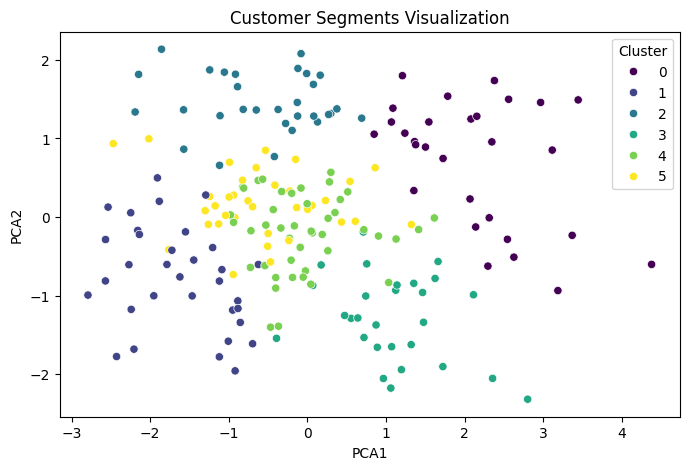

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(customer_profile_scaled)
customer_profile['PCA1'] = reduced_data[:, 0]
customer_profile['PCA2'] = reduced_data[:, 1]

plt.figure(figsize=(8, 5))
sns.scatterplot(data=customer_profile, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')
plt.title('Customer Segments Visualization')
plt.show()

**Step 6: Save Results**

Save the clustering results and metrics.

In [33]:
# Save customer profiles with clusters
customer_profile.to_csv("Customer_Clusters.csv", index=False)

# Save the DB Index value
with open("Clustering_Metrics.txt", "w") as f:
    f.write(f"Davies-Bouldin Index: {db_index}\n")